In [42]:
import psycopg2
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from psycopg2.extras import NamedTupleCursor
from Local_DB import DB_NAME, DB_HOST, DB_PORT, DB_USER, DB_PASSWD

plt.ioff()
sns.set(style='white')

In [2]:
DB_CONNECT_STRING = "dbname={0} host={1} port={2} user={3} password={4}".format(
    DB_NAME, DB_HOST, DB_PORT, DB_USER, DB_PASSWD
)
START_DATE = '2019-06-01'   # this day will be included
END_DATE   = '2019-06-30'   # and this also will be (we have dates only, not times)

PREV_START_DATE = '2019-05-01'  # start and stop dates for May's data to compare
PREV_END_DATE   = '2019-05-31'

В нашу задачу входит сравнение мая и июня, поэтому каждое CTE будет в двух вариантах: для майских пользователей и для июньских.  Варианты делаются из одного шаблона.  Ниже будут определяться дополнительные CTE.

In [3]:
# template for SQL expression: all users registered btw two dates list
USERS_CTE_TMPL = """ {0} as (
SELECT DISTINCT user_id, registration_date
    FROM case9.registration
    WHERE registration_date between '{1}' AND '{2}')
"""

JUN_USERS_CTE = USERS_CTE_TMPL.format('users_jun19', START_DATE, END_DATE)
MAY_USERS_CTE = USERS_CTE_TMPL.format('users_may19', PREV_START_DATE, PREV_END_DATE)

In [4]:
# functions
def init_connect(conn_string) -> psycopg2.extensions.cursor:
    db_conn = psycopg2.connect(conn_string, cursor_factory=NamedTupleCursor)
    cursor = None
    if db_conn:
        db_conn.set_session(readonly=True,autocommit=True)
        cursor = db_conn.cursor()
    return cursor

In [5]:
def _format_select(ctes: "list of CTEs", select: "SQL select") -> str:
    """Форматирует SQL запрос из списка CTE и выражения 'select', заданных соответственно первым
    и вторым параметрами"""
    query = ( "with " + ", ".join(ctes) + " " + select)
    if query[-1] != ';':
        query = query + ';'
    return query

In [6]:
def simple_query(cursor: "PsycoPg2 DB cursor", 
                 ctes: "list of CTEs", 
                 select: "select sql query as a string") -> str:
    """Запрос, после которого из базы возвращается одна строка, м.б. с несколькими полями.
    Параметры: 1) курсор базы, 2) SQL запрос
    Запрос должен возвращать одну строку (или возвращается первая строка)
    Возвращает: результат запроса
    Возможен возврат None.
    """
    query = _format_select(ctes, select)
    # print("*DBG* simple_query will execute:\n" + query)
    cursor.execute(query)
    first_line = cursor.fetchone()
    __ = cursor.fetchall()  # discard remaining lines
    return first_line

In [7]:
def multiline_query(cursor: "Database cursor", ctes: "list of CTEs", 
                    select: "select sql query as a string") -> list:
    """Запрос, возвращающий из базы много данных.
    Параметры: 1) Курсор PsycoPg2, 3) запрос SQL в виде строки.
    Возвращает: список Named Tuple-ов -- результат запроса. Если результатов
    нет, будет возвращён None."""
    query = _format_select(ctes, select)
    # print("*DBG* multiline_query will execute:\n" + query)
    cursor.execute(query)
    return cursor.fetchall()

In [8]:
cursor = init_connect(DB_CONNECT_STRING)

## Повторяем то, что написано в учебнике

In [9]:
users_count =  simple_query(cursor, [JUN_USERS_CTE],
                          'select count(user_id) from users_jun19;')
print(users_count)

Record(count=100423)


Использование DISTINCT под count() ничего не меняет, что означает, что дважды зарегистрированных пользователей с одним ID не бывает.  Запомним на будущее.

In [10]:
cursor = init_connect(DB_CONNECT_STRING)
users_count =  multiline_query(cursor, [JUN_USERS_CTE],
                          'select * from users_jun19 limit 3;')
print(users_count)

[Record(user_id='000032c7-0fc4-4382-bdc9-52891fe79077', registration_date=datetime.date(2019, 6, 4)), Record(user_id='0000ca0e-154f-41e7-a391-0e5a2fef11b4', registration_date=datetime.date(2019, 6, 8)), Record(user_id='00018971-c30b-4898-8d0d-8e6f43108ec8', registration_date=datetime.date(2019, 6, 16))]


In [11]:
COHORTS_TMPL = """{0} as (
    SELECT 
        ac.activity_date,
        u.registration_date,
        count(distinct(user_id)) as active_users_count
    FROM  case9.user_activity ac
    JOIN  {1} as u
    USING (user_id)
    GROUP BY ac.activity_date, u.registration_date
)"""

JUN_COHORTS_CTE = COHORTS_TMPL.format('cohorts_jun19', 'users_jun19')
MAY_COHORTS_CTE = COHORTS_TMPL.format('cohorts_may19', 'users_may19')

In [12]:
multiline_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE], "SELECT * from cohorts_jun19 limit 3;")

[Record(activity_date=datetime.date(2019, 6, 1), registration_date=datetime.date(2019, 6, 1), active_users_count=1651),
 Record(activity_date=datetime.date(2019, 6, 2), registration_date=datetime.date(2019, 6, 1), active_users_count=1429),
 Record(activity_date=datetime.date(2019, 6, 2), registration_date=datetime.date(2019, 6, 2), active_users_count=1933)]

Какое количество активных пользователей было зафиксировано на 10 июня 2019 для пользователей, зарегистрировавшихся 1 июня 2019 г.?

In [13]:
simple_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE], 
         """SELECT active_users_count from cohorts_jun19 
             WHERE registration_date='2019-06-01' 
                 AND activity_date='2019-06-10';""")[0]

483

### Определение Retention Rate

Для определения retention rate предлагается объединять датафреймы в памяти. У меня ещё никаких датафреймов нет, и вообще джойнить таблицы - это работа сервера БД.  Ему нужно только всё правильно объяснить. Для начала сделаю CTE для таблицы "дата регистрации - количество зарегистрированных пользователей".

In [14]:
USERS_BY_REGDATE_TMPL = """{0} as (
    SELECT registration_date, count(user_id) as registered_users_count
    FROM {1}
    GROUP BY registration_date
    ORDER BY registration_date
)"""

JUN_USERS_BY_REGDATE_CTE = USERS_BY_REGDATE_TMPL.format("users_by_registration_date_jun19", "users_jun19")
MAY_USERS_BY_REGDATE_CTE = USERS_BY_REGDATE_TMPL.format("users_by_registration_date_may19", "users_may19")

Проверю, что выдаются осмысленные результаты:

In [15]:
multiline_query(cursor, [JUN_USERS_CTE, JUN_USERS_BY_REGDATE_CTE], 
                "SELECT * from users_by_registration_date_jun19 limit 3;")

[Record(registration_date=datetime.date(2019, 6, 1), registered_users_count=4833),
 Record(registration_date=datetime.date(2019, 6, 2), registered_users_count=5255),
 Record(registration_date=datetime.date(2019, 6, 3), registered_users_count=4193)]

И напишу выражение для объединения таблиц.  Сразу посчитаю retention_rate и lifetime (кол-во дней с момента регистрации).

In [16]:
MONTH_RETENTION_TMPL = """{0} as (
    SELECT 
        activity_date, 
        registration_date, 
        registered_users_count, 
        active_users_count,
        active_users_count*1.0 / registered_users_count as retention_rate,
        activity_date - registration_date as lifetime
    FROM {1}
    JOIN {2}
    USING (registration_date) 
)"""

JUN_RETENTION_CTE = MONTH_RETENTION_TMPL.format('retention_jun19', 'cohorts_jun19', 
                                               'users_by_registration_date_jun19')
MAY_RETENTION_CTE = MONTH_RETENTION_TMPL.format('retention_may19', 'cohorts_may19', 
                                               'users_by_registration_date_may19')

In [17]:
multiline_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE, JUN_USERS_BY_REGDATE_CTE, JUN_RETENTION_CTE], 
                "SELECT * from retention_jun19 LIMIT 3;")

[Record(activity_date=datetime.date(2019, 6, 1), registration_date=datetime.date(2019, 6, 1), registered_users_count=4833, active_users_count=1651, retention_rate=Decimal('0.34160976619077177736'), lifetime=0),
 Record(activity_date=datetime.date(2019, 6, 2), registration_date=datetime.date(2019, 6, 1), registered_users_count=4833, active_users_count=1429, retention_rate=Decimal('0.29567556383198841299'), lifetime=1),
 Record(activity_date=datetime.date(2019, 6, 2), registration_date=datetime.date(2019, 6, 2), registered_users_count=5255, active_users_count=1933, retention_rate=Decimal('0.36784015223596574691'), lifetime=0)]

Какой Retention Rate наблюдается на 18 июня 2019 г. у пользователей когорты, зарегистрировавшихся 3 июня 2019 г.? Ответ дайте в процентах с точностью до двух знаков после точки-разделителя.

In [18]:
simple_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE, JUN_USERS_BY_REGDATE_CTE, JUN_RETENTION_CTE], 
                """SELECT round(retention_rate*100,2) AS retention_pct 
                FROM retention_jun19 
                WHERE activity_date='2019-06-18' AND registration_date='2019-06-03';
                """)[0]

Decimal('7.68')

Теперь сформируем сводную таблицу.

Агрегировать особо нечего, но в конечном итоге нужно получить таблицу, где строки -- дата регистрации, а колонки - lifetime. Исследумый месяц -- июнь, поэтому получится 30 строк (1-30 июня).  Сколько будет колонок, пока неизвестно, но узнать стоит.  Спрашиваю базу:

In [19]:
simple_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE, JUN_USERS_BY_REGDATE_CTE, JUN_RETENTION_CTE], 
                "SELECT max(lifetime) as max_lt from retention_jun19")

Record(max_lt=30)

Матрица 30×31 -- это меньше 1000 значений, считываю данные в датафрейм:

In [20]:
retention_df = pd.DataFrame(multiline_query(cursor, 
        [JUN_USERS_CTE, JUN_COHORTS_CTE, JUN_USERS_BY_REGDATE_CTE, JUN_RETENTION_CTE],
        """SELECT registration_date, lifetime, registered_users_count, active_users_count, retention_rate 
           FROM retention_jun19 
           ORDER BY registration_date, lifetime 
        """))
print(retention_df.head(3))

  registration_date  lifetime  registered_users_count  active_users_count  \
0        2019-06-01         0                    4833                1651   
1        2019-06-01         1                    4833                1429   
2        2019-06-01         2                    4833                1021   

           retention_rate  
0  0.34160976619077177736  
1  0.29567556383198841299  
2  0.21125594868611628388  


Получили таблицу в "длинном" формате, да ещё значения даты и `retention_rate` строковые (`object`). Для того, чтобы повторить изображённый в учебнике heatmap, нужно преобразовать данные и перевести таблицу в "широкий" формат.  Буду делать это больше одного раза (для майских и для июньских данных), поэтому нужно создать функцию.

In [21]:
def _fmt_date_and_set_idx(df: 'Pandas dataframe with columns "registration date" and "lifetime"') -> pd.DataFrame:
    """Внутренняя функция, преобразует формат даты и формирует мультииндекс"""
    df['registration_date'] = pd.to_datetime(df.registration_date)
    df = df.set_index(['registration_date', 'lifetime'])
    return df

def retention_df_cleanup(df: "Pandas dataframe with retention data") -> pd.DataFrame:
    """Преобразование типов данных для расчёта Retention Rate. Параметры: 1) Датафрейм с данными из базы
    Возвращает: тот же датафрейм, но с преобразованными параметрами и созданным иерерхическим индексом
    "дата регистрации - время жизни"
    """
    df['retention_rate'] = df.retention_rate.astype('float')
    return _fmt_date_and_set_idx(df)

# Нам понадобится аналогичная функция для датафрейма, который используется при расчёте ARPU, revenue и т.п.
def revenue_df_cleanup(df: "Pandas DF with revenue data") -> pd.DataFrame:
    """Преобразование форматов данных из строк в даты и числа"""
    df['day_lt_revenue'] = df.day_lt_revenue.astype('float')
    df['arpc'] = df.arpc.astype('float')
    return _fmt_date_and_set_idx(df)

In [22]:
retention_df = retention_df_cleanup(retention_df)
retention_pvt = retention_df['retention_rate'].unstack('lifetime')

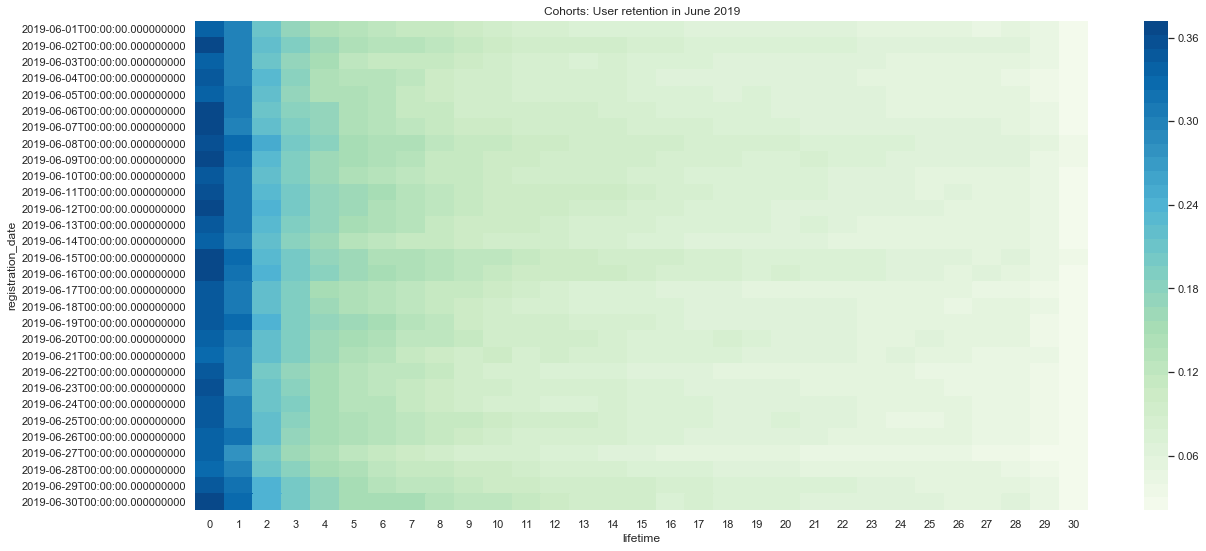

In [23]:
plt.figure(figsize=(20, 9))
plt.title('Cohorts: User retention in June 2019')
sns.heatmap(retention_pvt, annot=False, fmt='.0%', linewidths=0, cmap=sns.color_palette('GnBu', 36));
plt.show()


На мой вкус, цифры на heatmap-е только мешают восприятию, но это как кому нравится. Чтобы получить срез на определённый день, можно воспользоваться любым из датафреймов: `retention_df` или `retention_pvt`.

Как видим из диаграммы, retention rate в первые 3-4 дня во всех когортах спадает очень резко, затем спад делается более плавным. Когорты середины месяца (15-16 июня и последних двух-трёх дней держатся несколько дольше.  Заметного систематического изменения (тренда) между когортами не видно.

Из задания:
> Что можно сказать об изменении Retention Rate на 0-й день для дневных когорт июня 2019 г.?

In [24]:
retention_df.head(5)

registered_users_count  active_users_count  \
registration_date lifetime                                               
2019-06-01        0                           4833                1651   
                  1                           4833                1429   
                  2                           4833                1021   
                  3                           4833                 849   
                  4                           4833                 694   

                            retention_rate  
registration_date lifetime                  
2019-06-01        0               0.341610  
                  1               0.295676  
                  2               0.211256  
                  3               0.175667  
                  4               0.143596

Наш датафрейм с двухуровневым индексом, нужный массив данных из него получается методом `.xs`:

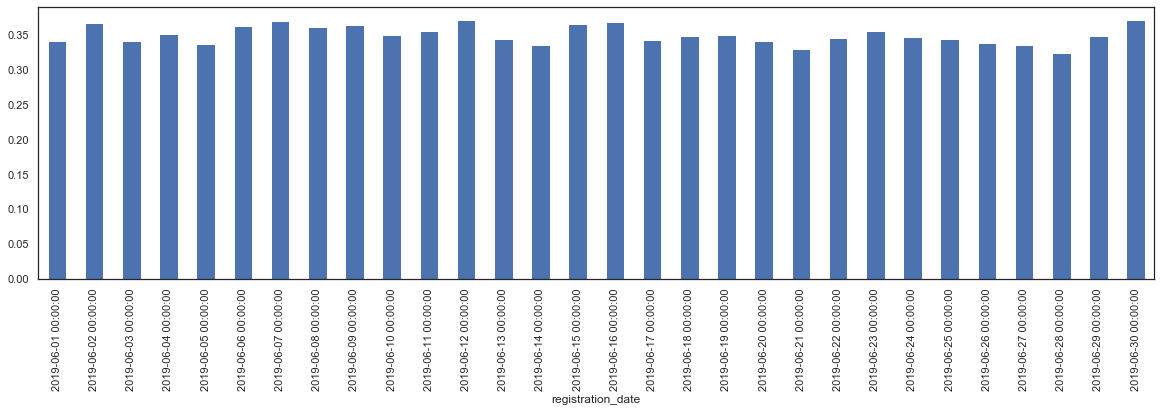

In [25]:
day0_df = retention_df['retention_rate'].xs(0, level='lifetime')
__ = day0_df.plot(kind='bar', figsize=(20,5))
plt.show()

Можно сказать, что `retention_rate` когорт на нулевой день колеблется около значения 0.35, но определённого тренда нет.

Аналогично на 7-й день:

> Что можно сказать об измнении Retention Rate на 7-й день в когорте зарегистрировашихся 30 июня относительно когорты 1 июня?

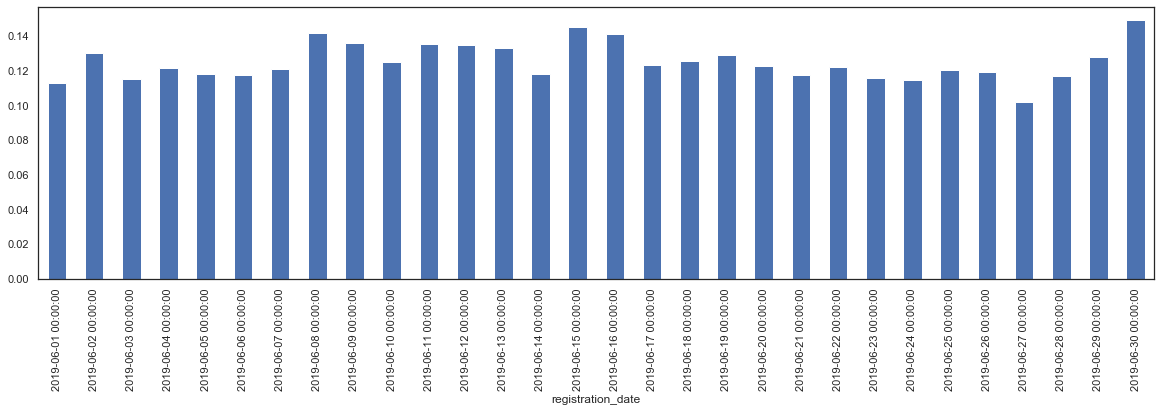

In [26]:
__ = retention_df['retention_rate'].xs(7, level='lifetime').plot(kind='bar', figsize=(20,5))
plt.show()

Можно сказать, что на 7-й день в когорте 30 июня retention rate увеличился по сравнению с 1 июля, хотя определённого линейного тренда в течение месяца не просматривается.  Разброс по дням также вырос.

> Рассчитайте для каждого дня lifetime усредненный Retention Rate по всем когортам июня 2019 г.
> Постройте график изменения среднего Retention Rate в июне 2019 г. в зависимости от времени жизни пользователя.
> Опишите, какие выводы можно сделать на основе графика изменения Retention Rate.

На мой вкус, интереснее показать не только среднее, но и разброс.  Да и среднее слишком чувствительно к выбросам.  Построю боксплоты по каждому дню лайфтайма, это даёт лучшее представление, чем просто среднее.

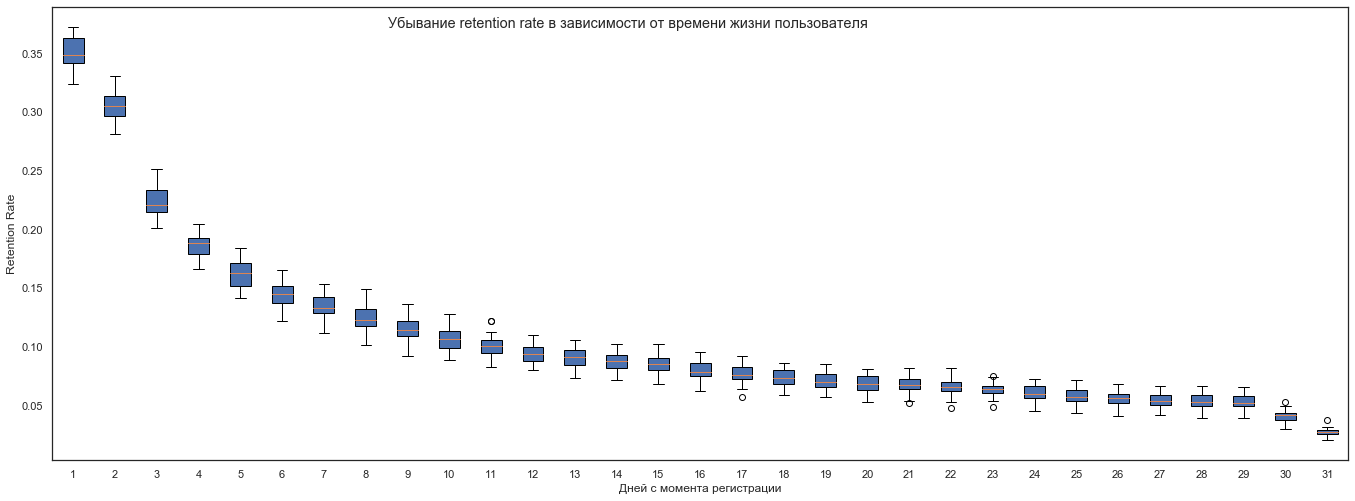

In [27]:
jun_ret_bp_list = [ retention_df.xs(lt, level='lifetime')['retention_rate'] for lt in range(0,31) ]
fig = plt.figure(figsize=(20,7))
ax = fig.add_axes((0.1, 0.1, 0.9, 0.9))
ax.set_xlabel('Дней с момента регистрации')
ax.set_ylabel('Retention Rate')
fig.suptitle('Убывание retention rate в зависимости от времени жизни пользователя')
__ = ax.boxplot(jun_ret_bp_list, notch=False, patch_artist=True)
plt.show()

График любопытный. Видно, что данные неплохо ложатся на линию обратной пропорциональности количеству дней с момента регистрации, и кривая вроде бы выходит на асимптоту, параллельную оси X, но только до 29-го дня.  Дальше следует резкий провал retention rate на тридцатом-тридцать первом дне.

Но просто значения — это малоинтересно, гораздо лучше смотреть динамику. Для этого нужно получить датафрейм, аналогичный данным июня 2019, только за май.  Тогда, наложив два графика, мы увидим разницу.

Получим из базы датафрейм для retention rate в мае:

In [28]:
may_retention_df = pd.DataFrame(multiline_query(cursor, 
        [MAY_USERS_CTE, MAY_COHORTS_CTE, MAY_USERS_BY_REGDATE_CTE, MAY_RETENTION_CTE],
        """SELECT registration_date, lifetime, registered_users_count, active_users_count, retention_rate 
           FROM retention_may19 
           ORDER BY registration_date, lifetime 
        """))

may_retention_df = retention_df_cleanup(may_retention_df)
print(may_retention_df.head(3))

                            registered_users_count  active_users_count  \
registration_date lifetime                                               
2019-05-01        0                           6516                2590   
                  1                           6516                2146   
                  2                           6516                1637   

                            retention_rate  
registration_date lifetime                  
2019-05-01        0               0.397483  
                  1               0.329343  
                  2               0.251228  


Для дальнейших построений объединим датафреймы и посчитаем разницу между retention rate в мае и в июне. Но есть проблема: у нас `registration_date` полная, поэтому датафреймы так просто не объединить. Нужно обрезать registration_date до дня месяца.

31-е число есть только в мае, поэтому в этот день июньский retention rate будет пустым. Убираю данные за 31-е мая.

In [29]:
may_rr_pre = may_retention_df.rename(columns={'retention_rate':'may_rr'}).reset_index()
may_rr_pre['registration_day'] = may_rr_pre.registration_date.dt.day
may_rr_pre = may_rr_pre.drop(['registration_date', 'registered_users_count', 'active_users_count'],
                             axis=1).take(range(0,30*31), axis=0)

# просто 'retention_df' - это июньские данные
jun_rr_pre = retention_df.rename(columns={'retention_rate':'jun_rr'}).reset_index()
jun_rr_pre['registration_day'] = jun_rr_pre.registration_date.dt.day
jun_rr_pre = jun_rr_pre.drop(['registration_date', 'registered_users_count', 'active_users_count'],
                             axis=1)

may_jun_retrate = may_rr_pre.merge(jun_rr_pre, on=('registration_day', 'lifetime'),how='left')
may_jun_retrate = may_jun_retrate.set_index(['registration_day', 'lifetime'])
may_jun_retrate['diff_rr'] = may_jun_retrate.jun_rr - may_jun_retrate.may_rr

# И проверяем, что в начале и в конце данных всё нормально.
print(may_jun_retrate.head())
print(may_jun_retrate.tail())

                             may_rr    jun_rr   diff_rr
registration_day lifetime                              
1                0         0.397483  0.341610 -0.055873
                 1         0.329343  0.295676 -0.033668
                 2         0.251228  0.211256 -0.039972
                 3         0.222683  0.175667 -0.047015
                 4         0.198895  0.143596 -0.055299
                             may_rr    jun_rr   diff_rr
registration_day lifetime                              
30               26        0.053064  0.058467  0.005404
                 27        0.051918  0.056347  0.004428
                 28        0.053636  0.059982  0.006346
                 29        0.041802  0.043623  0.001821
                 30        0.026341  0.027567  0.001226


 и разница пусты.

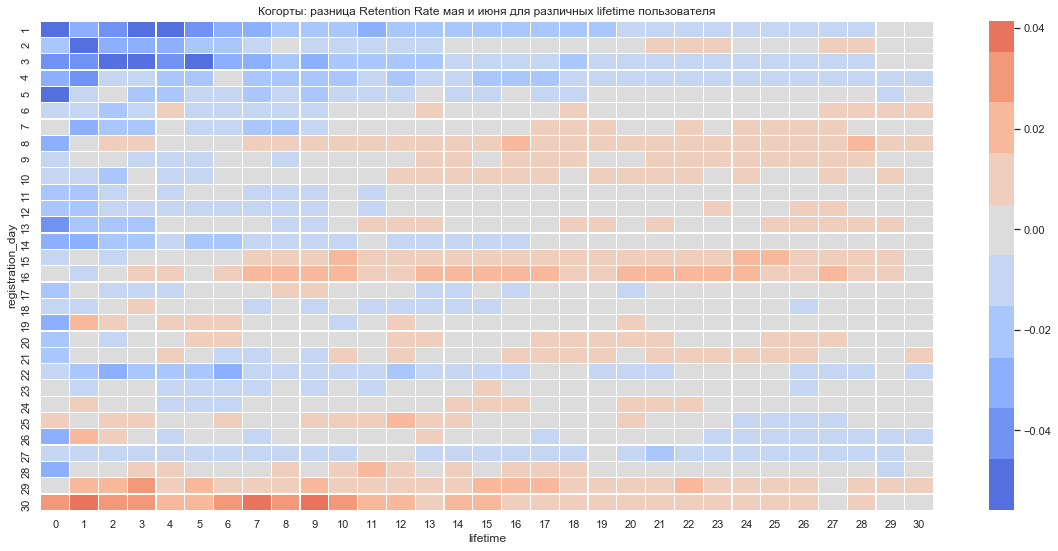

In [30]:
diff_pvt = may_jun_retrate.loc[:,'diff_rr'].unstack('lifetime')

plt.figure(figsize=(20, 9))
plt.title('Когорты: разница Retention Rate мая и июня для различных lifetime пользователя')
sns.heatmap(diff_pvt, annot=False, fmt='.0%', linecolor='white', linewidths=.2, center=0.0, cmap=sns.color_palette("coolwarm", 11));
plt.show()

Данные показывают, что есть некоторое снижение retention rate в в первые день-два в июньской когорте по сравнению с майской почти для всех когорт. Но это компенсируется лучшими показателями на более позних этапах жизненного цикла пользователя.  Есть уникальная когорта 30 июня, у которой retention rate заметно выше соответствующей майской когорты, есть когорты 15, 16, 29 июня, у которых RR тоже повыше майских.  В то же время существуют когорты 1, 3-4, 22, 17 июня, которые показывают худший RR по сравнению с маем.

Для того, чтобы сравнить средние по времени жизни показатели, можем вывести два графика в одних координатах.  Список `jun_ret_bp_list` у нас остался с предыдущего построения, создам новый, с майскими данными (`may_ret_bp_list`).


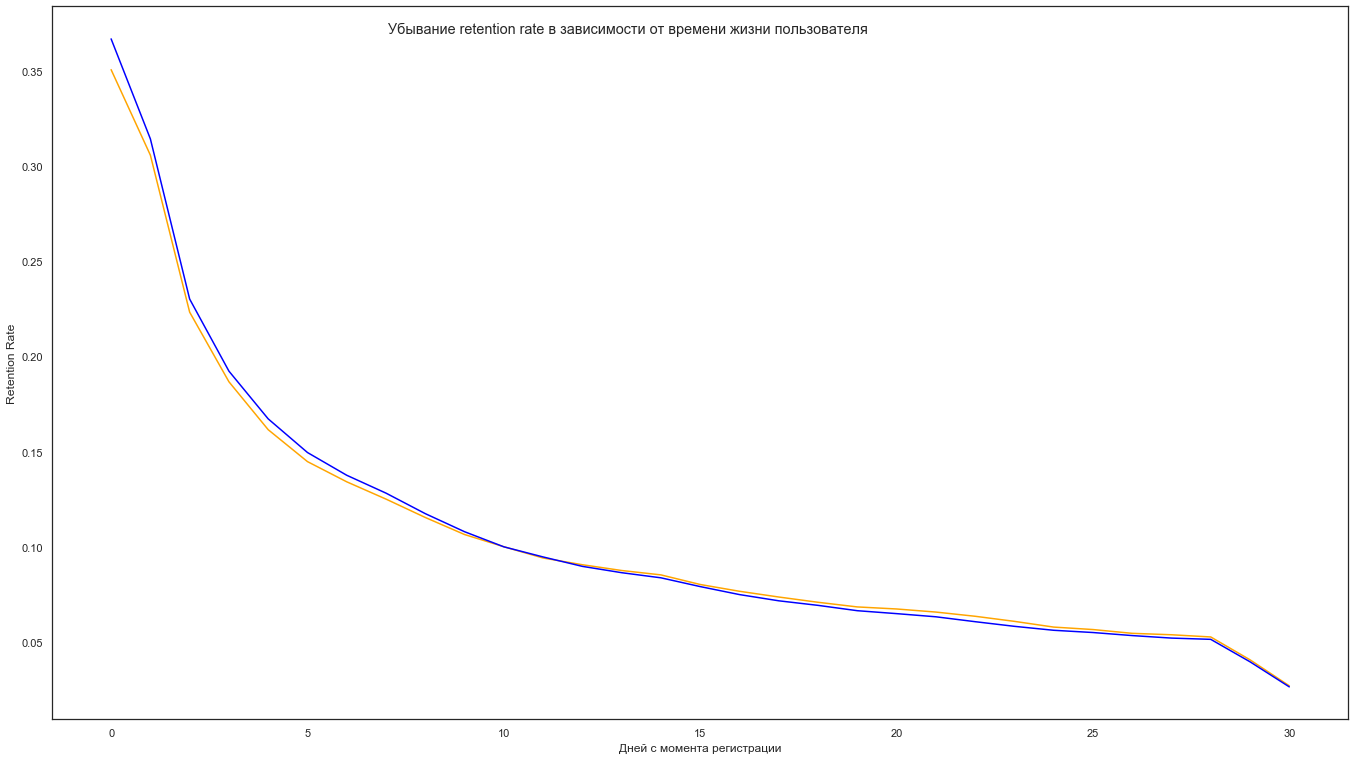

In [31]:
jun_ret_median_list = [ retention_df.xs(lt, level='lifetime')['retention_rate'].mean() for lt in range(0,31) ]
may_ret_median_list = [ may_retention_df.xs(lt, level='lifetime')['retention_rate'].mean() for lt in range(0,31) ]

fig = plt.figure(figsize=(20,11))
ax = fig.add_axes((0.1, 0.1, 0.9, 0.9))
ax.set_xlabel('Дней с момента регистрации')
ax.set_ylabel('Retention Rate')
fig.suptitle('Убывание retention rate в зависимости от времени жизни пользователя')
__ = ax.plot(jun_ret_median_list, color='orange')
__ = ax.plot(may_ret_median_list, color='blue')
# XXX Но я хочу боксплоты, а не только медианы!
plt.show()

Медианы ведут себя аналогично. До десятого дня июньские показатели чуть хуже майских, после десятого чуть лучше.

links:
https://matplotlib.org/devel/MEP/MEP28.html?highlight=multiple%20boxplots
https://matplotlib.org/devel/MEP/MEP28.html?highlight=multiple%20boxplots#mep28-remove-complexity-from-axes-boxplot
https://matplotlib.org/tutorials/introductory/customizing.html


## Самостоятельная работа

### Расчёт ARPU

Данные о доходах хранятся в таблице `case9.user_revenue` и имеют такую структуру:
```
dgolub=> \d case9.user_revenue
             Table "case9.user_revenue"
 Column  |  Type   | Collation | Nullable | Default 
---------+---------+-----------+----------+---------
 id      | integer |           | not null | 
 user_id | uuid    |           |          | 
 date    | date    |           |          | 
 revenue | real    |           |          | 
Indexes:
    "user_revenue_pkey" PRIMARY KEY, btree (id)
Foreign-key constraints:
    "user_id_ur_fk" FOREIGN KEY (user_id) REFERENCES case9.registration(user_id)
```

Начальные строки таблицы:

```
dgolub=> select * from case9.user_revenue limit 3;
   id   |               user_id                |    date    |  revenue  
--------+--------------------------------------+------------+-----------
 489601 | 85d1dec6-dc6e-4d06-993e-cb795fec9471 | 2019-06-03 |  0.530505
 489602 | 5ca30bf9-192b-4c87-9832-59ae717e8d6a | 2019-06-21 |  0.946369
 489603 | 090d5e7b-6d82-48b0-8201-831d4b05b520 | 2019-06-26 | 0.0231618
(3 rows)
```

Для того, чтобы получить доходы от пользователей, зарегистрированных в каком-либо месяце, нужно объединить эту таблицу с вырезкой для этого месяца из таблицы зарегистрированных пользователей.  Примерно так:
```
dgolub=> select * from case9.user_revenue join case9.registration using (user_id) limit 3;
               user_id                |   id   |    date    |  revenue  | registration_date 
--------------------------------------+--------+------------+-----------+-------------------
 85d1dec6-dc6e-4d06-993e-cb795fec9471 | 489601 | 2019-06-03 |  0.530505 | 2019-06-02
 5ca30bf9-192b-4c87-9832-59ae717e8d6a | 489602 | 2019-06-21 |  0.946369 | 2019-06-21
 090d5e7b-6d82-48b0-8201-831d4b05b520 | 489603 | 2019-06-26 | 0.0231618 | 2019-06-09
```

Надо заметить, что на пользователя приходится заметно больше одной покупки:
``` 
dgolub=> select 
    count(user_id)*1.0/count(distinct user_id) as apc 
    from 
        case9.user_revenue 
        join case9.registration 
        using (user_id) 
    where registration_date between '2019-06-01' and '2019-06-30';
    
        apc         
--------------------
 2.2946964378722344
```

Для исследования доходов нужно получить данные в формате: дата регистрации - время жизни - доход. Можно добавить и дополнительные колонки, например, ARPU (поделив доход на количество пользователей).

In [32]:
MONTH_REVENUE_TMPL = """{0} as (SELECT 
    ur.registration_date, 
    re.date - ur.registration_date as lifetime, 
    count(distinct(re.user_id)) as users_count_with_revenue, 
    sum(re.revenue) as revenue 
FROM 
    case9.user_revenue re
    INNER JOIN 
    {1} as ur 
    USING (user_id)
GROUP BY ur.registration_date, lifetime
)"""

JUN_RVN_CTE = MONTH_REVENUE_TMPL.format('jun_users_revenue', 'users_jun19')

jun_users_revenue = simple_query(cursor, [JUN_USERS_CTE, JUN_RVN_CTE], 
                                    'select sum(revenue) from jun_users_revenue;'
                                   )[0]
print("Общий грязный доход с июньских пользователей:", jun_users_revenue)

Общий грязный доход с июньских пользователей: 79685.88


In [33]:
jun_users_count = simple_query(cursor, [JUN_USERS_CTE], 'select count(distinct user_id) from users_jun19;')[0]
print("Количество зарегистрированных в июне пользователей:", jun_users_count)
print("АRPU в июне:", jun_users_revenue/jun_users_count)

Количество зарегистрированных в июне пользователей: 100423
АRPU в июне: 0.7935022853330412


Из учебника ARPU в мае около 0.65, что даёт нам неплохой прирост июньского ARPU по отношению к майскому, около 23%.

### Распределение ARPU по дням: когорты и lifetime

Строить нужную выдачу из базы будем поэтапно.  Сначала получим revenue по пользователям (не только по покупателям).

In [34]:
USERS_REVENUE_TMPL = """{0} as (SELECT 
    id, 
    user_id, 
    registration_date, 
    date as trans_date,
    (date - registration_date) as lifetime, 
    revenue
FROM
    {1}
    INNER JOIN
    case9.user_revenue USING (user_id)
ORDER BY registration_date, lifetime
)"""

MAY_USERS_REVENUE_CTE = USERS_REVENUE_TMPL.format('may_revenue_by_user', 'users_may19')
JUN_USERS_REVENUE_CTE = USERS_REVENUE_TMPL.format('jun_revenue_by_user', 'users_jun19')

Используется `INNER JOIN`, потому что пользователей будем считать другим способом, из этих таблиц неудобно (лучше из `user_activity`). Пока что получим ARPC, а не ARPU.

Проверяем, что выдаётся осмысленный результат:

In [35]:
print("Валовой доход в мае {0} и в июне {1}".format(
      (simple_query(cursor, [MAY_USERS_CTE, MAY_USERS_REVENUE_CTE],"""
            SELECT count(distinct user_id), sum(revenue) from may_revenue_by_user;""")[1]),
      (simple_query(cursor, [JUN_USERS_CTE, JUN_USERS_REVENUE_CTE],"""
            SELECT count(distinct user_id), sum(revenue) from jun_revenue_by_user;""")[1])))

Валовой доход в мае 122007.81 и в июне 79685.89


In [40]:
REVENUE_DF_REQ_TMPL = """
    SELECT registration_date,
        lifetime,
        count(distinct user_id) as buyers,
        sum(revenue) as day_lt_revenue,
        sum(revenue) * 1.0 / count(distinct user_id) as arpc
    FROM
        {0}
    GROUP BY registration_date, lifetime
    ORDER BY registration_date, lifetime
"""

may_revenue_df = revenue_df_cleanup(
    pd.DataFrame(multiline_query(cursor, [MAY_USERS_CTE, MAY_USERS_REVENUE_CTE],
                REVENUE_DF_REQ_TMPL.format('may_revenue_by_user'))))

jun_revenue_df = revenue_df_cleanup(
    pd.DataFrame(multiline_query(cursor, [JUN_USERS_CTE, JUN_USERS_REVENUE_CTE],
                REVENUE_DF_REQ_TMPL.format('jun_revenue_by_user'))))

In [41]:
jun_revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 833 entries, (2019-06-01 00:00:00, 0) to (2019-06-30 00:00:00, 30)
Data columns (total 3 columns):
buyers            833 non-null int64
day_lt_revenue    833 non-null float64
arpc              833 non-null float64
dtypes: float64(2), int64(1)
memory usage: 21.9 KB


Из полученных датафреймов можно получить сводные таблицы по нужным колонкам. Revenue убыывает очень быстро, причём механизмов убывания видно два: сокращение количества покупателей и снижение дохода на покупателя (ARPC). Интереснее вывести ARPC:


In [83]:
may_arpc_pvt = may_revenue_df['arpc'].unstack('lifetime')
jun_arpc_pvt = jun_revenue_df['arpc'].unstack('lifetime')

Два следующих блока кода закомментированы (обозначены как raw block), при желании их можно пометить как
код и выполнить.  Картинки не очень интересные: из-за разницы масштабов тяжело сделать выводы. Ниже выведу разницу, она более показательна.

Для получения разницы между датафреймами нужно поправить индексы: сейчас они представляют собой даты, а нам нужны только номера дней в месяце. Можно выделить день из даты, а можно просто пронумеровать колонки, потому что они последовательны с первого до последнего дня месяца.

In [84]:
def prep_pvt_table_for_diff(df: 'Pandas DF, pivot table with date on index and lifetimes as columns') -> pd.DataFrame:
    """Подготовка датафреймов к вычитанию: переиндексация номерами дней в месяце и замена NaN-ов нулями"""
    df = df.reset_index()
    df['registration_day'] = df.registration_date.dt.day
    df = df.set_index(['registration_day']).drop('registration_date', axis=1)
    df = df.fillna(0).take(range(0,30), axis=0)
    return df

may_arpc_pvt = prep_pvt_table_for_diff(may_arpc_pvt)
jun_arpc_pvt = prep_pvt_table_for_diff(jun_arpc_pvt)
diff_arpc_pvt = jun_arpc_pvt - may_arpc_pvt
diff_arpc_pvt

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_day,,,,,,,,,,,,,,,,,,,,,
1,0.079667,-0.020060,-0.064422,-0.148113,-0.192650,0.248676,0.921490,0.379312,-0.184826,-0.089229,...,0.044067,0.551653,0.103482,-0.417546,0.054582,0.191723,1.046293,0.130606,-0.062351,-0.254574
2,-0.153404,0.092029,-0.176951,-0.142817,-0.228464,-0.014382,-0.062789,-0.219775,0.047512,0.184180,...,-0.804292,-0.017134,0.097562,-0.088593,1.178490,0.078065,-0.027403,0.067689,-0.215194,0.621719
3,0.206224,-0.027257,-0.081473,-0.252215,-0.000259,0.375573,-0.367441,-0.107182,-0.125108,-0.123886,...,0.174448,-0.423997,0.437409,-0.160023,0.049826,0.076388,-0.253008,-0.095343,0.052796,-0.316597
4,0.054829,0.270894,-0.134152,0.163905,0.147368,0.170959,-0.109980,0.005274,0.193601,0.647350,...,-0.152057,0.231390,-0.274467,0.013603,0.017525,-0.019829,-0.118986,0.340497,-0.331050,-0.146816
5,0.067675,-0.244261,0.500977,-0.008487,0.266062,-0.189722,-0.056386,0.012165,0.069210,0.625168,...,0.028473,-0.054721,0.100363,0.384873,0.057946,0.481470,0.167695,0.493598,0.037205,0.411542
6,0.468188,-0.087301,0.091904,0.226552,-0.200056,-0.064755,0.327265,-0.199217,-0.120199,0.110646,...,0.310270,-0.041371,0.001222,-0.120040,-0.247982,0.387222,0.866434,-0.040443,-0.159818,0.000000
7,0.216798,0.169715,0.021174,-0.051078,0.112767,0.714172,0.125697,0.032160,-0.174834,0.131531,...,0.183511,0.023149,-0.164744,0.163706,0.176376,0.053796,0.208686,1.758215,0.090593,-0.285376
8,0.267786,0.292540,0.047742,-0.066764,0.012425,0.321930,0.204125,-0.301044,-0.093292,0.208893,...,-0.138336,-0.047931,0.180390,-0.503043,0.132776,0.163646,-0.162046,0.000000,1.153295,-0.341546
9,0.440379,0.003060,0.116754,-0.307495,0.423456,0.014860,0.340270,0.493896,-0.059145,-0.472709,...,-0.074059,-0.022782,-0.172682,-0.070342,0.026873,0.063255,0.265332,-0.370232,0.026622,0.000000


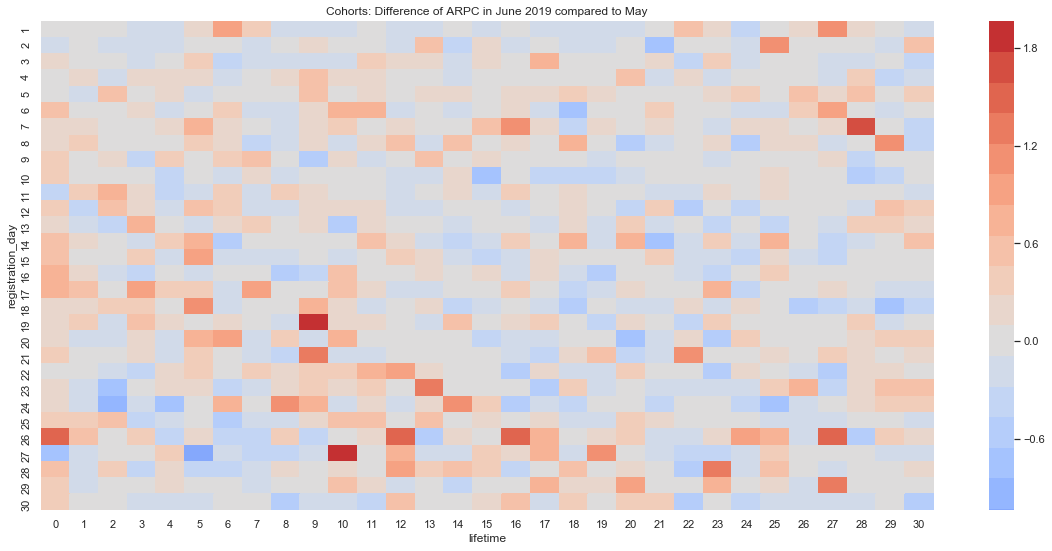

In [85]:
plt.figure(figsize=(20, 9))
plt.title('Cohorts: Difference of ARPC in June 2019 compared to May')
sns.heatmap(diff_arpc_pvt, annot=False, fmt='.0%', linewidths=0, center=0.0, cmap=sns.color_palette("coolwarm", 21))
plt.show()

Видно, что ARPC в июне повысился по сравнению с маем.  Если построить график средней разницы по когортам в зависимости от времени жизни, он будет в основном положительным:

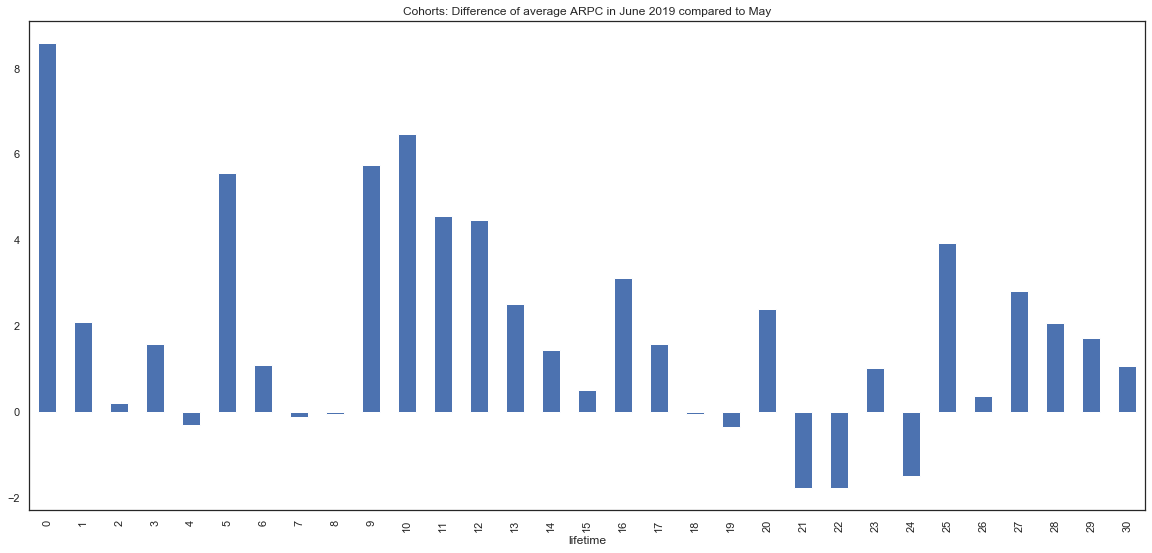

In [90]:
plt.figure(figsize=(20, 9))
plt.title('Cohorts: Difference of average ARPC in June 2019 compared to May')
diff_arpc_pvt.sum(axis=0, numeric_only=True).plot(kind='bar')
plt.show()

Мы выяснили, что каждый покупатель в июне платит немного больше.  Но может оказаться, что это компенсируется более низкой конверсией.  Нужно расчитать доход на пользователя, а не только на покупателя.